### Lets load all of our Libraries

In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import pickle

#our machine learning functions
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#our neural network functions
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#our custom functions
import homemade_functions as hf

#our graphing functions
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

### Load up our pre-processed data
 - Choosing to run our You can choose which dataset to run through, I ran the clean set on this visual

In [ ]:
file_path = "../../data/" 
# choice_of_dataset = "lemma_dataset" #Pick one leave the other two commented out.
choice_of_dataset = "clean_dataset"
# choice_of_dataset = "stem_dataset"
ds_train = Dataset.load_from_disk(f"{file_path}{choice_of_dataset}/train")
ds_test = Dataset.load_from_disk(f"{file_path}{choice_of_dataset}/test")

In [ ]:
df_test = pd.DataFrame(data=ds_test)
df_train = pd.DataFrame(data=ds_train)
display(df_test.head())
df_train.head()

,label,text
0,0,"[got, new, tires, within, two, weeks, got, fla..."
1,0,"[dont, waste, time, two, different, people, co..."
2,0,"[say, worst, 2, people, place, lunch, place, f..."
3,0,"[restaurant, twice, disappointed, times, wont,..."
4,0,"[food, good, husband, ate, couple, weeks, ago,..."


,label,text
0,2,"[dr, goldberg, offers, everything, look, gener..."
1,0,"[unfortunately, frustration, dr, goldbergs, pa..."
2,2,"[going, dr, goldberg, 10, years, think, one, 1..."
3,2,"[got, letter, mail, last, week, said, dr, gold..."
4,0,"[dont, know, dr, goldberg, like, moving, arizo..."


For interest sake we will see how many unique words we still have in the dataset (train, test) and how many we have that are in one but not the other

In [174]:
unique_words_train = hf.word_count(df_train['text'])
unique_words_test = hf.word_count(df_test['text'])
difference = unique_words_train ^ unique_words_test
print(f"There are {len(unique_words_train)} unique words in the Train dataset")
print(f"There are {len(unique_words_test)} unique words in the Test dataset")
print(f"There are {len(difference)} words that only appear in one dataset")
print(f"There are {len(unique_words_test - unique_words_train)} that appear in the Test set but not the Train set")

There are 836750 unique words in the Train dataset
There are 135881 unique words in the Test dataset
There are 792815 words that only appear in one dataset
There are 45973 that appear in the Test set but not the Train set


## Lets get started on TF-IDF
 - we need to revert everything to strings not tokens for this

In [ ]:
df_train['text_string'] = df_train['text'].apply(hf.string_it)
df_test['text_string'] = df_test['text'].apply(hf.string_it)
display(df_test.head())
df_train.head()

,label,text,text_string
0,0,"[got, new, tires, within, two, weeks, got, fla...",got new tires within two weeks got flat took c...
1,0,"[dont, waste, time, two, different, people, co...",dont waste time two different people come hous...
2,0,"[say, worst, 2, people, place, lunch, place, f...",say worst 2 people place lunch place freezing ...
3,0,"[restaurant, twice, disappointed, times, wont,...",restaurant twice disappointed times wont go ba...
4,0,"[food, good, husband, ate, couple, weeks, ago,...",food good husband ate couple weeks ago first t...


,label,text,text_string
0,2,"[dr, goldberg, offers, everything, look, gener...",dr goldberg offers everything look general pra...
1,0,"[unfortunately, frustration, dr, goldbergs, pa...",unfortunately frustration dr goldbergs patient...
2,2,"[going, dr, goldberg, 10, years, think, one, 1...",going dr goldberg 10 years think one 1st patie...
3,2,"[got, letter, mail, last, week, said, dr, gold...",got letter mail last week said dr goldberg mov...
4,0,"[dont, know, dr, goldberg, like, moving, arizo...",dont know dr goldberg like moving arizona let ...


Have had issues with computing power so there is an option to reduce our sample size here (not limiting test set)

In [ ]:

sample_size = df_train.shape[0] # how many rows of our train dataset we will use, leave at shape[0] for all
max_features = 20000 # how many features we will use if BoW and TF-IDF

#shuffle the dataframe as we are taking the top n number of rows and I do not want any organisation in that to bias the results
df_train = df_train.sample(frac=1).reset_index(drop=True) 

#split my train test split
X_train = df_train['text_string'].head(sample_size)
X_test = df_test['text_string']
y_train = df_train['label'].head(sample_size)
y_test = df_test['label']


### Lets run our TFIDF now

In [177]:
tfidf_vect = TfidfVectorizer(
    max_df=0.95,
    max_features = max_features,
    stop_words=None
)

#fit and transform the TFIDF
tfidf_vect.fit(X_train)
tfidf_train_matrix = tfidf_vect.transform(X_train)
tfidf_test_matrix = tfidf_vect.transform(X_test)


### Lets also do Bag of Words with count vectorizer

In [178]:
bow_vect = CountVectorizer(max_features=max_features)

#Fit and transform all the data for Bag of Words
bow_vect.fit(X_train)
bow_train_matrix = bow_vect.transform(X_train)
bow_test_matrix = bow_vect.transform(X_test)

 - We can save both of those models for later use


In [179]:
with open(f'{file_path}models/tfidf_vect.pkl', 'wb') as file:
  pickle.dump(tfidf_vect, file)

with open(f'{file_path}models/bow_vect.pkl', 'wb') as file:
  pickle.dump(bow_vect, file)

### Lets run Logistic Regression on both Bag of Words and TF-IDF

In [180]:
bwLogistic_model = LogisticRegression(max_iter=10000)
bwLogistic_model.fit(bow_train_matrix, y_train)

bwlog_preds = bwLogistic_model.predict(bow_test_matrix)
bw_log_metrics, bwlog_conf_matrix = hf.accuracy_scorer(y_test, bwlog_preds)
confusion_matrices = [bwlog_conf_matrix]
matrices_titles = ['BW_Logistic_Regression']

In [181]:
tfLogistic_model = LogisticRegression(max_iter=10000)

tfLogistic_model.fit(tfidf_train_matrix, y_train)
tflog_preds = tfLogistic_model.predict(tfidf_test_matrix)
tf_log_metrics, tflog_conf_matrix = hf.accuracy_scorer(y_test, tflog_preds)
confusion_matrices.append(tflog_conf_matrix)
matrices_titles.append("TF-IDF_Logistic_Regression")

In [182]:
complete_metrics = {"BoW Logistic Regression": bw_log_metrics,
                    "TF-IDF Logistic Regression": tf_log_metrics}

 - lastly lets check and compare our metrics 

In [183]:
model_type = "Logistic Regression"

print(f"Sample size:{sample_size} and Max Features: {max_features}")
print(f"\n{model_type} Accuracy: \nTF-IDF: {tf_log_metrics[0]} vs BoW: {bw_log_metrics[0]}")
print(f"\n{model_type} R2: \nTF-IDF: {tf_log_metrics[1]} vs BoW: {bw_log_metrics[1]}")
print(f"\n{model_type} MSE:\nTF-IDF: {tf_log_metrics[2]} vs BoW: {bw_log_metrics[2]}")
print(f"\n{model_type} Precision:\nTF-IDF: {tf_log_metrics[3]} vs BoW: {bw_log_metrics[3]}")
print(f"\n{model_type} Recall:\nTF-IDF: {tf_log_metrics[4]} vs BoW: {bw_log_metrics[4]}")
print(f"\n{model_type} F1 Score:\nTF-IDF: {tf_log_metrics[5]} vs BoW: {bw_log_metrics[5]}")
print(f"\n{model_type}n Confusion Matrix:\nTF-IDF:")
print(tflog_conf_matrix)
print("\nvs Bow Confusion Matrix")
print(bwlog_conf_matrix)

Sample size:650000 and Max Features: 20000

Logistic Regression Accuracy: 
TF-IDF: 0.77466 vs BoW: 0.76614

Logistic Regression R2: 
TF-IDF: 0.56795 vs BoW: 0.5438000000000001

Logistic Regression MSE:
TF-IDF: 0.34564 vs BoW: 0.36496

Logistic Regression Precision:
TF-IDF: 0.7597871658188474 vs BoW: 0.7497300139740958

Logistic Regression Recall:
TF-IDF: 0.77466 vs BoW: 0.76614

Logistic Regression F1 Score:
TF-IDF: 0.7637877834307656 vs BoW: 0.7539176658213511

Logistic Regressionn Confusion Matrix:
TF-IDF:
[[17389  1607  1004]
 [ 2968  3939  3093]
 [ 1001  1594 17405]]

vs Bow Confusion Matrix
[[17122  1676  1202]
 [ 3000  3700  3300]
 [  983  1532 17485]]


 - And save those for later use

In [184]:
with open(f'{file_path}models/logisitic_model_tf_01.pkl', 'wb') as file:
    pickle.dump(tfLogistic_model, file)

with open(f'{file_path}models/logistic_model_bw_01.pkl', 'wb') as file:
    pickle.dump(bwLogistic_model, file)

### Lets try out Random Forest next

In [185]:
bwRandomForest_model = RandomForestClassifier(n_estimators=100, max_depth=10)
bwRandomForest_model.fit(bow_train_matrix, y_train)

bwrf_preds = bwRandomForest_model.predict(bow_test_matrix)

bw_RF_metrics, bwrf_conf_matrix = hf.accuracy_scorer(y_test, bwrf_preds)
confusion_matrices.append(bwrf_conf_matrix)
matrices_titles.append("BoW_RandomForest")

In [186]:
tfRandomForest_model = RandomForestClassifier(n_estimators=100, max_depth=10)
tfRandomForest_model.fit(tfidf_train_matrix, y_train)

tfrf_preds = tfRandomForest_model.predict(tfidf_test_matrix)

tf_RF_metrics, tfrf_conf_matrix = hf.accuracy_scorer(y_test, tfrf_preds)
confusion_matrices.append(tfrf_conf_matrix)
matrices_titles.append("TF-IDF_RandomForest")
complete_metrics.update({"BoW Random Forest": bw_RF_metrics,
                         "TF-IDF Random Forest": tf_RF_metrics})

 - Compare the metrics

In [187]:
model_type = "Random Forest"
print(f"Sample size:{sample_size} and Max Features: {max_features}")
print(f"\n{model_type} Regression Accuracy: \nTF-IDF: {tf_RF_metrics[0]} vs BoW: {bw_RF_metrics[0]}")
print(f"\n{model_type} R2: \nTF-IDF: {tf_RF_metrics[1]} vs BoW: {bw_RF_metrics[1]}")
print(f"\n{model_type} MSE:\nTF-IDF: {tf_RF_metrics[2]} vs BoW: {bw_RF_metrics[2]}")
print(f"\n{model_type} Precision:\nTF-IDF: {tf_RF_metrics[3]} vs BoW: {bw_RF_metrics[3]}")
print(f"\n{model_type} Recall:\nTF-IDF: {tf_RF_metrics[4]} vs BoW: {bw_RF_metrics[4]}")
print(f"\n{model_type} F1 Score:\nTF-IDF: {tf_RF_metrics[5]} vs BoW: {bw_RF_metrics[5]}")
print(f"\n{model_type} Confusion Matrix:\nTF-IDF:")
print(tfrf_conf_matrix)
print("\nvs Bow Confusion Matrix")
print(bwrf_conf_matrix)

Sample size:650000 and Max Features: 20000

Random Forest Regression Accuracy: 
TF-IDF: 0.64482 vs BoW: 0.64594

Random Forest R2: 
TF-IDF: -0.025900000000000034 vs BoW: -0.020299999999999985

Random Forest MSE:
TF-IDF: 0.82072 vs BoW: 0.81624

Random Forest Precision:
TF-IDF: 0.5215336048566818 vs BoW: 0.5239886585575555

Random Forest Recall:
TF-IDF: 0.64482 vs BoW: 0.64594

Random Forest F1 Score:
TF-IDF: 0.5731938587831062 vs BoW: 0.5741656033043363

Random Forest Confusion Matrix:
TF-IDF:
[[14739     0  5261]
 [ 3888     0  6112]
 [ 2498     0 17502]]

vs Bow Confusion Matrix
[[14579     0  5421]
 [ 3768     0  6232]
 [ 2282     0 17718]]


- And save

In [188]:
with open(f'{file_path}models/random_forest_model_tf_01.pkl', 'wb') as file:
    pickle.dump(tfRandomForest_model, file)

with open(f'{file_path}models/random_forest_model_bw_01.pkl', 'wb') as file:
    pickle.dump(bwRandomForest_model, file)

### Lets go for XGB next

In [189]:
bwxgb_model = xgb.XGBClassifier(objective='multi:softmax',  # Regression objective
                             n_estimators=100,  # Number of boosting rounds
                             learning_rate=0.1,  # Step size shrinkage
                             max_depth=6,  # Maximum tree depth
                             random_state=42)
bwxgb_model.fit(bow_train_matrix, y_train)

bwxgb_preds = bwxgb_model.predict(bow_test_matrix)

bw_XGB_metrics, bwxgb_conf_matrix = hf.accuracy_scorer(y_test, bwxgb_preds)
confusion_matrices.append(bwxgb_conf_matrix)
matrices_titles.append("BoW_XGB")

In [190]:
tfxgb_model = xgb.XGBClassifier(objective='multi:softmax',  # Regression objective
                             n_estimators=100,  # Number of boosting rounds
                             learning_rate=0.1,  # Step size shrinkage
                             max_depth=6,  # Maximum tree depth
                             random_state=42)
tfxgb_model.fit(tfidf_train_matrix, y_train)

tfxgb_preds = tfxgb_model.predict(tfidf_test_matrix)

tf_XGB_metrics, tfxgb_conf_matrix = hf.accuracy_scorer(y_test, tfxgb_preds)
confusion_matrices.append(tfxgb_conf_matrix)
matrices_titles.append("TF-IDF_XGB")
complete_metrics.update({"BoW XGB": bw_XGB_metrics,
                         "TF-IDF XGB": tf_XGB_metrics})

 - Compare the metrics

In [191]:
model_type = "XGB Boost"
print(f"Sample size:{sample_size} and Max Features: {max_features}")
print(f"\n{model_type} Regression Accuracy: \nTF-IDF: {tf_XGB_metrics[0]} vs BoW: {bw_XGB_metrics[0]}")
print(f"\n{model_type} R2: \nTF-IDF: {tf_XGB_metrics[1]} vs BoW: {bw_XGB_metrics[1]}")
print(f"\n{model_type} MSE:\nTF-IDF: {tf_XGB_metrics[2]} vs BoW: {bw_XGB_metrics[2]}")
print(f"\n{model_type} Precision:\nTF-IDF: {tf_XGB_metrics[3]} vs BoW: {bw_XGB_metrics[3]}")
print(f"\n{model_type} Recall:\nTF-IDF: {tf_XGB_metrics[4]} vs BoW: {bw_XGB_metrics[4]}")
print(f"\n{model_type} F1 Score:\nTF-IDF: {tf_XGB_metrics[5]} vs BoW: {bw_XGB_metrics[5]}")
print(f"\n{model_type} Confusion Matrix:\nTF-IDF:")
print(tfxgb_conf_matrix)
print("\nvs Bow Confusion Matrix")
print(bwxgb_conf_matrix)

Sample size:650000 and Max Features: 20000

XGB Boost Regression Accuracy: 
TF-IDF: 0.70952 vs BoW: 0.7086

XGB Boost R2: 
TF-IDF: 0.2682 vs BoW: 0.2663

XGB Boost MSE:
TF-IDF: 0.58544 vs BoW: 0.58696

XGB Boost Precision:
TF-IDF: 0.689430115199303 vs BoW: 0.6879164302547387

XGB Boost Recall:
TF-IDF: 0.70952 vs BoW: 0.7086

XGB Boost F1 Score:
TF-IDF: 0.6846657516901945 vs BoW: 0.6834397597200873

XGB Boost Confusion Matrix:
TF-IDF:
[[16819   996  2185]
 [ 3937  2382  3681]
 [ 2731   994 16275]]

vs Bow Confusion Matrix
[[16721   979  2300]
 [ 3905  2350  3745]
 [ 2626  1015 16359]]


- And save

In [192]:
with open(f'{file_path}models/xgb_model_tf_01.pkl', 'wb') as file:
    pickle.dump(tfxgb_model, file)

with open(f'{file_path}models/xgb_model_bw_01.pkl', 'wb') as file:
    pickle.dump(bwxgb_model, file)

### Lets build our basic neural network

In [193]:

class EnhancedNN(nn.Module):
    def __init__(self, input_size, num_classes=5):
        super(EnhancedNN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        out = self.relu3(out)

        out = self.fc4(out)
        out = self.softmax(out)
        return out

 - Convert all of our data to relevant and run it with both Bag of Words and TF-IDF

In [194]:
X_train_tensor = hf.sparse_mx_to_torch_sparse_tensor(bow_train_matrix)
X_test_tensor = hf.sparse_mx_to_torch_sparse_tensor(bow_test_matrix)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


bwmodel = EnhancedNN(tfidf_train_matrix.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bwmodel.parameters())
with torch.no_grad():
  y_pred_probs = bwmodel(X_test_tensor)
  _, bwy_pred = torch.max(y_pred_probs, 1)

bw_torch_metrics, bwtorch_conf_matrix = hf.accuracy_scorer(y_test_tensor, bwy_pred)
confusion_matrices.append(bwtorch_conf_matrix)
matrices_titles.append("BoW_Neural_network")

c:\Users\finch\anaconda3\envs\test_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [195]:
X_train_tensor = hf.sparse_mx_to_torch_sparse_tensor(tfidf_train_matrix)
X_test_tensor = hf.sparse_mx_to_torch_sparse_tensor(tfidf_test_matrix)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


tfmodel = EnhancedNN(tfidf_train_matrix.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tfmodel.parameters())
with torch.no_grad():
  y_pred_probs = tfmodel(X_test_tensor)
  _, tfy_pred = torch.max(y_pred_probs, 1)

tf_torch_metrics, tftorch_conf_matrix = hf.accuracy_scorer(y_test_tensor, tfy_pred)
confusion_matrices.append(tftorch_conf_matrix)
matrices_titles.append("TF-IDF_Neural_network")
# complete_metrics.update({"BoW NN": bw_torch_metrics,
#                          "TF-IDF NN": tf_torch_metrics}) # neural network results are absolute trash and I'm not adding them to the graphs below

 - Compare the metrics

In [196]:
model_type = "Torch Neural Network"
print(f"Sample size:{sample_size} and Max Features: {max_features}")
print(f"\n{model_type} Regression Accuracy: \nTF-IDF: {tf_torch_metrics[0]} vs BoW: {bw_torch_metrics[0]}")
print(f"\n{model_type} R2: \nTF-IDF: {tf_torch_metrics[1]} vs BoW: {bw_torch_metrics[1]}")
print(f"\n{model_type} MSE:\nTF-IDF: {tf_torch_metrics[2]} vs BoW: {bw_torch_metrics[2]}")
print(f"\n{model_type} Precision:\nTF-IDF: {tf_torch_metrics[3]} vs BoW: {bw_torch_metrics[3]}")
print(f"\n{model_type} Recall:\nTF-IDF: {tf_torch_metrics[4]} vs BoW: {bw_torch_metrics[4]}")
print(f"\n{model_type} F1 Score:\nTF-IDF: {tf_torch_metrics[5]} vs BoW: {bw_torch_metrics[5]}")
print(f"\n{model_type} Confusion Matrix:\nTF-IDF:")
print(tftorch_conf_matrix)
print("\nvs Bow Confusion Matrix")
print(bwtorch_conf_matrix)


Sample size:650000 and Max Features: 20000

Torch Neural Network Regression Accuracy: 
TF-IDF: 0.4 vs BoW: 0.2202

Torch Neural Network R2: 
TF-IDF: -1.25 vs BoW: -0.15492499999999998

Torch Neural Network MSE:
TF-IDF: 1.8 vs BoW: 0.92394

Torch Neural Network Precision:
TF-IDF: 0.16 vs BoW: 0.19303620076230474

Torch Neural Network Recall:
TF-IDF: 0.4 vs BoW: 0.2202

Torch Neural Network F1 Score:
TF-IDF: 0.22857142857142856 vs BoW: 0.13192669261523132

Torch Neural Network Confusion Matrix:
TF-IDF:
[[    0     0 20000]
 [    0     0 10000]
 [    0     0 20000]]

vs Bow Confusion Matrix
[[ 2128 17846     0    26]
 [ 1110  8882     0     8]
 [ 2325 17654     0    21]
 [    0     0     0     0]]


- And save the models

In [197]:

with open(f'{file_path}models/torchNN_model_tf_01.pkl', 'wb') as file:
    pickle.dump(tfmodel, file)

with open(f'{file_path}models/torchNN_model_bw_01.pkl', 'wb') as file:
    pickle.dump(bwmodel, file)

### Lastly lets dive into our metrics a little better

In [198]:
df_metrics = pd.DataFrame(complete_metrics).T

metric_names = ['Accuracy', 'R-squared', 'MSE', 'Precision', 'Recall', 'F1-score']
df_metrics.index.name = "Model"
df_metrics.columns = metric_names
df_metrics

,Accuracy,R-squared,MSE,Precision,Recall,F1-score
Model,,,,,,
BoW Logistic Regression,0.76614,0.54380,0.36496,0.749730,0.76614,0.753918
TF-IDF Logistic Regression,0.77466,0.56795,0.34564,0.759787,0.77466,0.763788
BoW Random Forest,0.64594,-0.02030,0.81624,0.523989,0.64594,0.574166
TF-IDF Random Forest,0.64482,-0.02590,0.82072,0.521534,0.64482,0.573194
BoW XGB,0.70860,0.26630,0.58696,0.687916,0.70860,0.683440
TF-IDF XGB,0.70952,0.26820,0.58544,0.689430,0.70952,0.684666


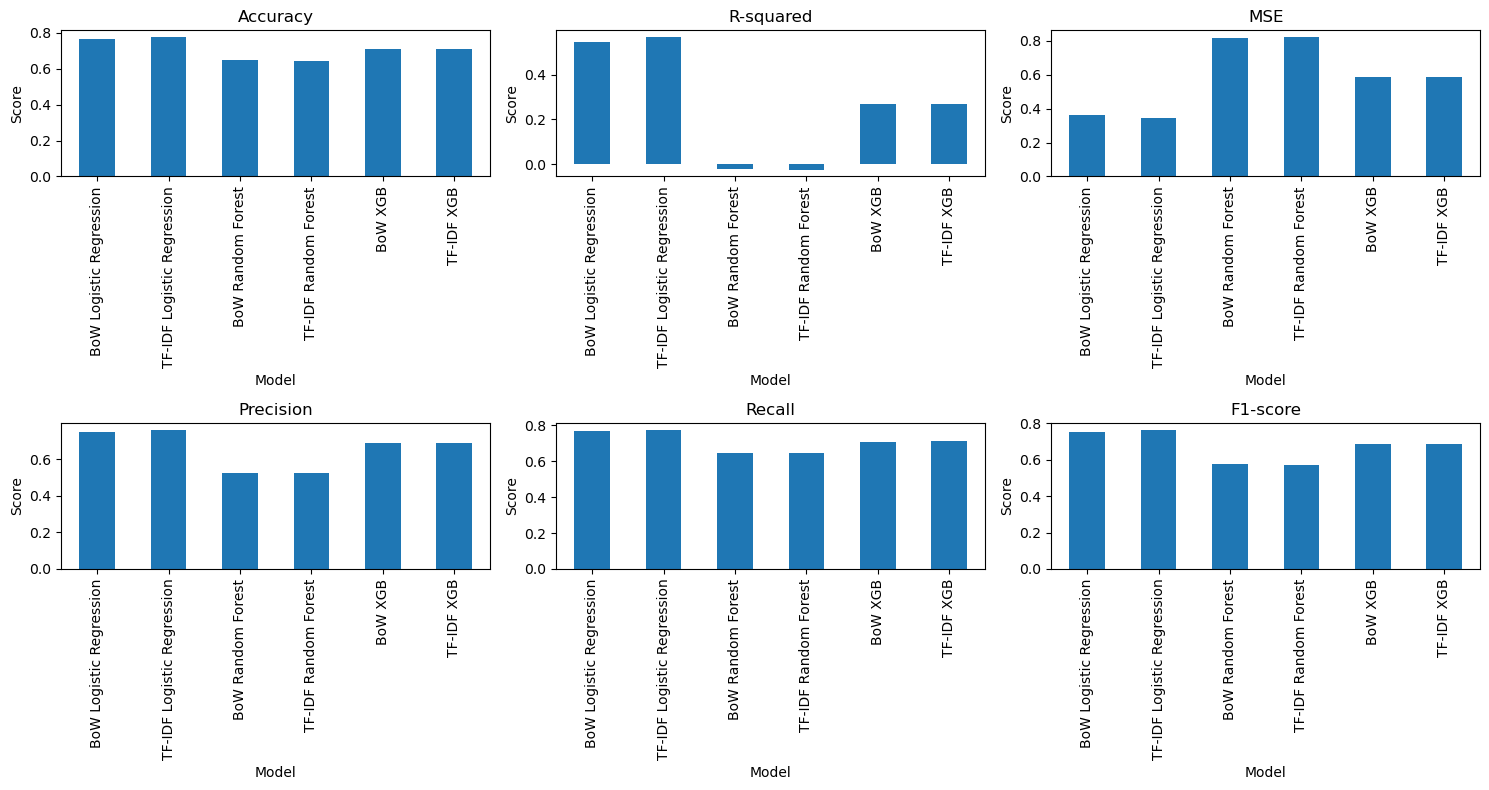

In [201]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8)) # 2 rows, 3 columns

for i, metric in enumerate(metric_names):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df_metrics[metric].plot(kind='bar', ax=ax)
    ax.set_title(metric)
    ax.set_ylabel('Score')
    ax.tick_params(axis='x')

# Remove the extra subplot if there are an odd number of graphs
if len(metric_names) < 6:
  fig.delaxes(axes[1,2])

plt.tight_layout()
plt.show()

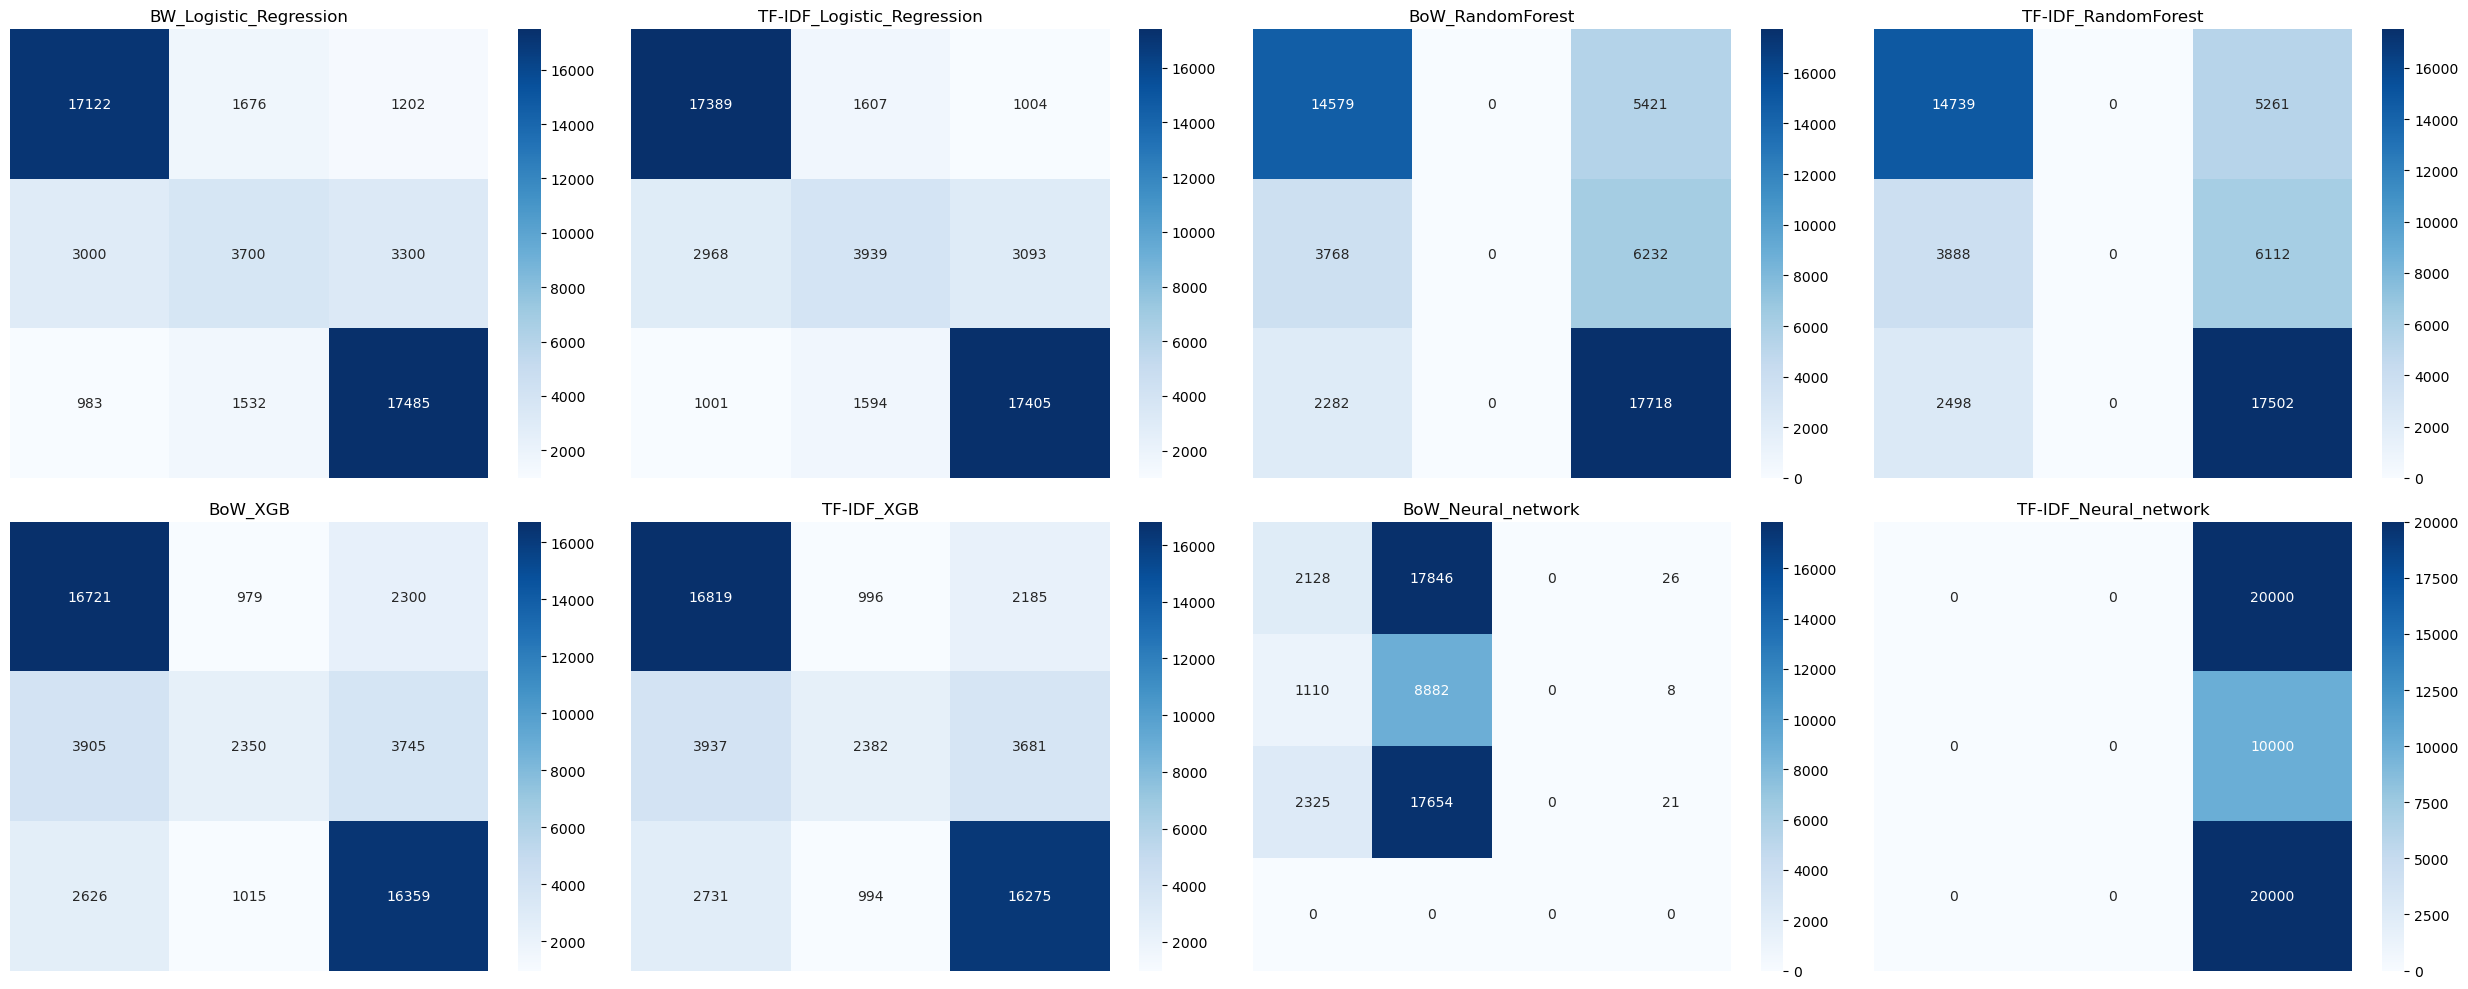

In [202]:
fig, axes = plt.subplots(2, 4, figsize=(25, 10))  # 1 row, 7 columns

for i, cm in enumerate(confusion_matrices):
    row = i // 4  # Calculate row index
    col = i % 4   # Calculate column index
    ax = axes[row, col]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(matrices_titles[i])

    ax.set_xticks([])
    ax.set_yticks([])



plt.tight_layout()
plt.show()

We can see some varying results, none great but currently getting the best results from basic Logistic regression techniques